## SNO+ Scattering Pseudo-MC
A simple test using known results to determine the viability of nuclear recoil
explaining the odd behaviour at 2.2 MeV.

In [39]:
# importing the usual suspects
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# random number generation
import random
# i just picked an arbitrary seed here
# if it matters it's easy to change
random.seed("snoplus")

plt.rcParams['figure.figsize'] = (12, 8)

In [40]:
# now we read in the stopping power data from ASTAR
stoppingpowers = pd.read_csv(Path("stoppingpowers/paraffin.csv"))
# rename cols to make them easier to reference
stoppingpowers.columns = ["KE", "electron", "nuclear", "total"]
# reindex the dataframe by kinetic energy to make lookups easier
#stoppingpowers.set_index("KE", inplace=True)
print(stoppingpowers)

            KE  electron    nuclear  total
0       0.0010     194.0  289.00000  483.0
1       0.0015     233.0  260.00000  493.0
2       0.0020     266.0  238.00000  503.0
3       0.0025     294.0  219.00000  514.0
4       0.0030     320.0  204.00000  524.0
..         ...       ...        ...    ...
116   800.0000      19.1    0.00655   19.1
117   850.0000      18.4    0.00617   18.4
118   900.0000      17.7    0.00582   17.7
119   950.0000      17.1    0.00552   17.2
120  1000.0000      16.6    0.00524   16.6

[121 rows x 4 columns]


So now we have the stopping power data available to us and formatted nicely.

**NB**: the initial revision here is without scattering to get a grip on things

The setup is that we have some sort of particle with a given energy E_0 (i'm not sure exactly what yet -
need to figure that out)
The general process goes like this:
- Look up stopping power in the table for the energy of our event
- Find dE (**NOTE**: need to figure out what dx will be here first - see
  wikipedia page for stopping power)
- Add dE to the bin for an event of that energy
- Repeat this, as if we had an energy of E_j = E_0 - dE
- Terminate once E_j is less than some given epsilon (generally close to zero -
  but we will never reach zero exactly)

Implementation notes: Can use recursion, but that is setting myself up for a
nightmare so let's keep things iterative

Also - how to deal with events which aren't exactly a given KE in the table.
Data is nonlinear but describes the derivative of energy w.r.t. position - the
function "looks like" it is C-infinity (ie. continuous derivatives) and differentiability
implies linearity in a neighbourhood so a linear interpolation should be a very
accurate estimation 

In [41]:
# Let's set up the bins for events here
# I don't know of any prepackaged solution for this so let's write a structure
# to hold binned data for us

# this kind of seems unnecessary to me, but also I would be implementing the
# exact same logic in a messier form otherwise so I digress
class CountBin:
    def __init__(self, low, high):
        self._low = low
        self._high = high
        self._count = 0
    
    # setting properties for the bin count
    @property
    def count(self):
        return self._count

    @count.setter
    def count(self, new_count):
        self._count = new_count

    # increment and decrement convenience functions
    def increment(self):
        self.count = self._count + 1       

    def decrement(self):
        self.count = self._count - 1

    # properties for bin bounds
    @property
    def low_range(self):
        return self._low

    @property
    def high_range(self):
        return self._high

    def __str__(self):
        return f"CountBin(low={self.low_range}, high={self.high_range}, count={self.count})"
    

class BinnedCountData:
    def __init__(self, num_bins, d=None, startpoint=0, endpoint=1):
        if d != None:
            low = min(d)
            high = max(d)
        else:
            low = startpoint
            high = endpoint

        self.binEdges = np.linspace(low, high, num_bins+1)

        self.bins = []

        i = 0
        while i < len(self.binEdges)-1:
            self.bins.append(CountBin(self.binEdges[i], self.binEdges[i+1]))
            i += 1


    def get_bin_index(self, v):
        i = 0
        while i < len(self.binEdges) - 1:
            if v <= self.binEdges[i+1]:
                return i
            i += 1


    @property
    def bin_min(self):
        return min(self.binEdges)
    
    @property
    def bin_max(self):
        return max(self.binEdges)

    @property
    def bin_edges(self):
        return self.binEdges

    # add a value to the correct count bin
    def add_count_by_value(self, v):
        # TODO is there a faster algorithm for this?
        self.bins[self.get_bin_index(v)].increment()

    # count an entire list
    def add_count_by_list(self, l):
        for i in l:
            self.count_value(i)

    @property
    def counts(self):
        return [i.count for i in self.bins]

    def get_count_by_value(self, v):
        # get count of a bin some value is in
        return self.bins[self.get_bin_index(v)].count

Now we do the linear interpolation of the ASTAR data
Although the data is nonlinear, this is still decently accurate since it is a differentiable function 

In [42]:
# now to do the linear interpolation for the ASTAR dataset
def stp_interp(e, stp=stoppingpowers):
    # NOTE this assumes that the stopping powers are sorted
    # we get them this way from ASTAR so it's not an issue, but we can fix that if need be
    for k in stoppingpowers.index:
        if e >= stoppingpowers["KE"].max():
            return (stoppingpowers["total"].iloc(-1))/(stoppingpowers["KE"].iloc(-1))*e
        elif e <= stoppingpowers["KE"][k+1] and e >= stoppingpowers["KE"][k]:
            ke_low = stoppingpowers["KE"][k]
            sp_low = stoppingpowers["total"][k]
            ke_high = stoppingpowers["KE"][k+1]
            sp_high = stoppingpowers["total"][k+1]
            break

    return ((sp_high - sp_low)/(ke_high - ke_low)) * e + sp_low


In [49]:
def scattering_probability(e):
    # this Z is for paraffin
    # TODO work out for LAB
    Z = 62
    # the closest approach distance
    D = 197.3/137 * (2*Z)/e

    #working out the approximate nuclear area 
    R_0 = 1.2E-15 
    R = np.power(Z, 1/3)*R_0
    nuclear_area = np.pi*np.power(R, 2)

    sigma = np.pi * np.power(D, 2) * 1E8
    
    return sigma/nuclear_area

    # returning a constant probability for now until we figure things out

print(scattering_probability(2.2))

2.9209273805705334e+40


Now, let's do the simulation.

In [44]:
stepsize = 0.00001 # this is our dx
e_0 = 14 # initial energy in MeV, it's arbitrary right now
epsilon = 0.1
density = 0.92 # of paraffin for now, is in g/cm3

sim_data = BinnedCountData(40, startpoint=0, endpoint=e_0)

# now to run the simulation
e_i = e_0
while e_i > epsilon:
    # TODO figure out sampling distribution for scattering
    if scattering_probability(e_i) > random.random():
        continue
    else:
        sim_data.add_count_by_value(e_i)
        e_i = e_i - stp_interp(e_i)*stepsize*density


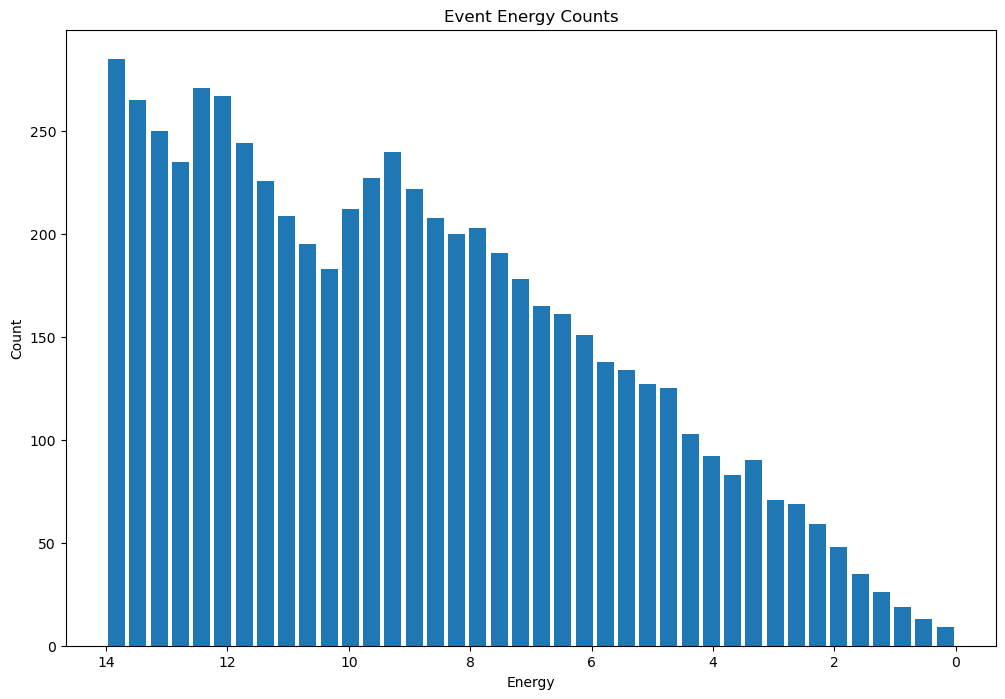

In [45]:
# now to plot the simulation results
#plt.stairs(sim_data.counts, sim_data.bin_edges)
plt.hist(sim_data.bin_edges[:-1], sim_data.bin_edges, weights=sim_data.counts, rwidth=0.8)
plt.xlabel("Energy")
plt.ylabel("Count")
plt.gca().invert_xaxis()
plt.title("Event Energy Counts")
plt.show()